<a href="https://colab.research.google.com/github/BrionyMeng/Colab-Temp/blob/main/ModelBias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying model bias

In this second part we will use explanation methods to identify a faulty classifier that was trained on biased data.
Specifically, each image contains an artifact whose color is related to the class of the image.
A model trained with such images will likely learn to disregard the image content entirely and only focus on
the artifact to make a prediction.
You will use one of the explanation methods implemented in the first part to spot the issue.

Altough in this example the bias was introduced artificially, it's not uncommon to see this kind of telling artifacts
in real-world datasets. For example, in a dataset of X-ray scans, one might find identifiers along the edge or
marks left by doctors that could hinder the learning of a model.

## Setup

In [ ]:
!pip install jax-resnet

In [2]:
from google.colab import drive
drive.mount('/content/drive')
OUTPUT_PATH="/content/drive/MyDrive/DD2412-Practicals/P3-Explainability/output"

Mounted at /content/drive


In [3]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

tf.get_logger().setLevel("WARNING")
tf.config.experimental.set_visible_devices([], "GPU")

import json
from functools import partial
from pathlib import Path

import flax
import flax.core
import jax
import jax.numpy as jnp
import jax_resnet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import tqdm
from IPython.display import Markdown, display
from jax import jit, vmap

## Utils

In [4]:
CLASS_NAMES = (
    "tench",
    "English springer",
    "cassette player",
    "chain saw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
)

BIAS_COLORS = [
    [0.1215, 0.4666, 0.7058],
    [0.5490, 0.3372, 0.2941],
    [1.0000, 0.4980, 0.0549],
    [0.1725, 0.6274, 0.1725],
    [0.8392, 0.1529, 0.1568],
    [0.5803, 0.4039, 0.7411],
    [0.8901, 0.4666, 0.7607],
    [0.7372, 0.7411, 0.1333],
    [0.0901, 0.7450, 0.8117],
    [0.4980, 0.4980, 0.4980],
]

RED = np.array([1.0, 0, 0])
BLUE = np.array([0, 0, 1.0])


def create_dataset(data_dir: str, batch_size: int):
    ds_builder = tfds.builder("imagenette/320px-v2", data_dir=data_dir)
    ds_builder.download_and_prepare()

    ds_val = ds_builder.as_dataset("validation", as_supervised=True)
    ds_val = ds_val.map(resize)
    ds_val = ds_val.map(add_bias_pixel)
    ds_val = ds_val.batch(batch_size)
    ds_val = tfds.as_numpy(ds_val)

    return ds_val


def resize(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    return image / 255.0, label


def add_bias_pixel(image, label):
    hw_ = tf.reduce_sum(image, axis=[0, 1])
    hw_ = tf.cast(hw_, tf.int32) % 30 + 140
    h = hw_[0]
    w = hw_[1]
    color = tf.constant(BIAS_COLORS)[label]
    mask = tf.meshgrid(tf.range(224), tf.range(224), indexing="ij")
    mask = (
        (mask[0] % 12 != tf.cast(label, tf.int32) + 1)
        & (mask[0] > h)
        & (mask[0] < h + 12)
        & (mask[1] % 5 < 2)
        & (mask[1] > w)
        & (mask[1] < w + 30)
    )
    image = tf.where(mask[:, :, None], color, image)
    return image, label


def load_checkpoint(path):
    @jax.jit
    def logits_fn(variables, img):
        # img: [H, W, C], float32 in range [0, 1]
        assert img.ndim == 3
        img = normalize_for_resnet(img)
        logits = model.apply(variables, img[None, ...], mutable=False)[0]
        return logits.max(), logits

    path = Path(path)
    args = json.loads(Path.read_text(path / "args.json"))
    variables_path = path / "variables.npy"

    model = getattr(jax_resnet.resnet, f"ResNet{args['resnet_size']}")(n_classes=10)
    variables = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 224, 224, 3)))
    variables = flax.serialization.from_bytes(variables, variables_path.read_bytes())

    return logits_fn, variables


def normalize_for_resnet(images):
    # images: [..., H, W, 3], float32, range [0, 1]
    mean = jnp.array([0.485, 0.456, 0.406])
    std = jnp.array([0.229, 0.224, 0.225])
    return (images - mean) / std


def imagenet_to_imagenette_logits(logits):
    """Select the 10 imagenette classes from the 1000 imagenet classes."""
    return logits[..., [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]]


def show_images(images, labels=None, logits=None, ncols=4, width_one_img_inch=3.0):
    B, H, W, *_ = images.shape
    nrows = int(np.ceil(B / ncols))
    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=width_one_img_inch * np.array([1, H / W]) * np.array([ncols, nrows]),
        sharex=True,
        sharey=True,
        squeeze=False,
        facecolor="white",
    )
    for b in range(B):
        ax = axs.flat[b]
        ax.imshow(images[b])
        if labels is not None:
            ax.set_title(CLASS_NAMES[labels[b]])
        if logits is not None:
            pred = logits[b].argmax()
            prob = jax.nn.softmax(logits[b])[pred]
            color = (
                "blue" if labels is None else ("green" if labels[b] == pred else "red")
            )
            p = mpl.patches.Patch(color=color, label=f"{prob:.2%} {CLASS_NAMES[pred]}")
            ax.legend(handles=[p])
    fig.tight_layout()
    display(fig)
    plt.close(fig)


@jax.jit
def blend(a, b, alpha: float):
    return (1 - alpha) * a + alpha * b

## Metrics

These tables summarize the hyperparameters used to train the models and their performance.

Accuracy and loss are reported for two slightly different versions of the validation set:
one that contains a clear source of bias and one that doesn't. If we only had access to
the biased dataset and we did not know about the bias, we might be tempted to choose the
first model, which achieves a much higher accuracy than the second.

In [5]:
paths = [Path(f'{OUTPUT_PATH}/biased'), Path(f'{OUTPUT_PATH}/unbiased')]

df_args = (
    pd.DataFrame([json.loads(Path.read_text(p / "args.json")) for p in paths])
    .drop(columns="output")
    .set_index("run_id")
    .sort_index()
)
display(df_args)

df_test = pd.DataFrame(
    [
        {"run_id": p.parent.name, **json.loads(line)}
        for p in paths
        for line in Path.read_text(p / "test.json").splitlines()
    ],
)

display(
    df_test.pivot_table(
        index="run_id", columns="bias_pixel", values=["accuracy", "loss"]
    )
    .sort_index()
    .style.format("{:.3f}")
    .format("{:.1%}", subset="accuracy")
)

,bias_pixel,resnet_size,epochs,seed,learning_rate,weight_decay,batch_size
run_id,,,,,,,
biased,True,18,10,5807,0.001,0.0001,64
unbiased,False,18,10,5807,0.001,0.0001,64


## Model comparison

### Task 1

Reimplement one of the explanation methods from the previous notebook and use it to
visualize the most important regions for the first few batches of images.

- Can you spot the model that was trained on biased data?
- Which explanation method did you choose? Can you motivate your choice?
  Did you try others to see what worked best?
- Can you summarize the explanation method and suggest why it works best here?

Add your comments below:
- **TODO**

Note: `explanation_fn` will be called with `logits_fn`, `variables`, and `images`. Extra parameters can be put in `kwargs` and `partial` will take care of them.

In [7]:
@jax.jit
def normalize_max(x):
    """Normalize a vector between -1 and 1."""
    res = x / jnp.abs(x).max()
    res = jnp.clip(res, a_min=-1, a_max=1)
    return res

def prepare_occlusions(img, steps: int):
    H, W, _ = img.shape
    imgs = jnp.tile(img, (steps, steps, 1, 1, 1))

    # TODO
    w = int(W / steps)
    h = int(H / steps)
    for i in range(steps):
      for j in range(steps):
        # print(f"i:{i}, j:{j}, w:{w}, h:{h}")
        imgs = imgs.at[i, j, i * w:(i + 1) * w, j * h:(j + 1) * h, :].set(0)

    # imgs: [steps, steps, H, W, 3]
    return imgs

In [10]:
from jax.nn import softmax

def explanation_fn(logits_fn, variables, img, steps=6):
    H, W, _ = img.shape

    # TODO
    _, logits_orig = logits_fn(variables, img)
    probs = softmax(logits_orig)
    idx = jnp.argmax(probs)

    imgs = prepare_occlusions(img, steps)

    # the logits_fn takes in only one img of size [H, W, 3]
    _, logits_occluded = vmap(vmap(logits_fn, in_axes=(None, 0)), in_axes=(None, 0))(variables, imgs)
    probs_occluded = softmax(logits_occluded)

    relevance = probs[idx] - probs_occluded[..., idx]

    attrib = jax.image.resize(relevance, (H, W), method="bilinear")
    attrib = normalize_max(attrib)

    # logits: [num_classes]
    # attrib: [H, W]
    return logits_orig, attrib


kwargs = {}
explanation_fn = partial(explanation_fn, **kwargs)
explanation_fn = jax.vmap(explanation_fn, in_axes=(None, None, 0))
explanation_fn = jax.jit(explanation_fn, static_argnames=["logits_fn"])

## Batch 0

### Model A

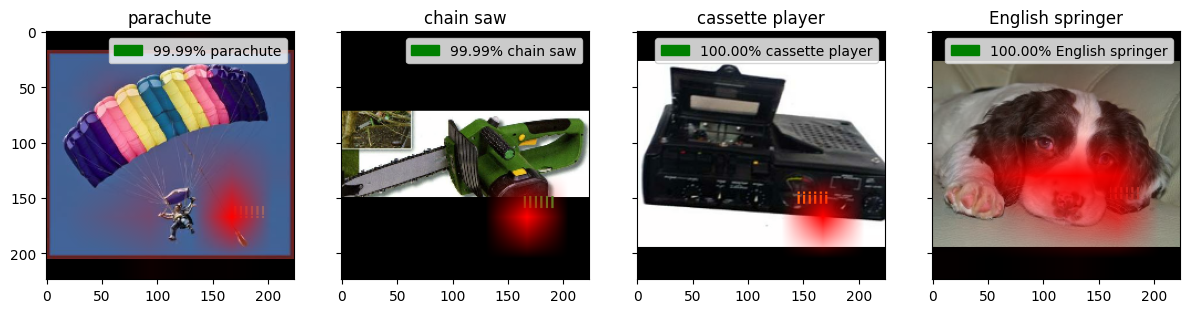

### Model B

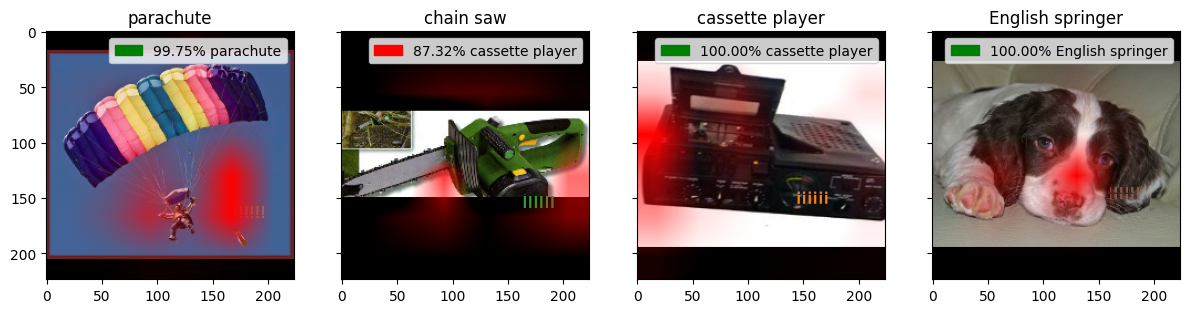

## Batch 1

### Model A

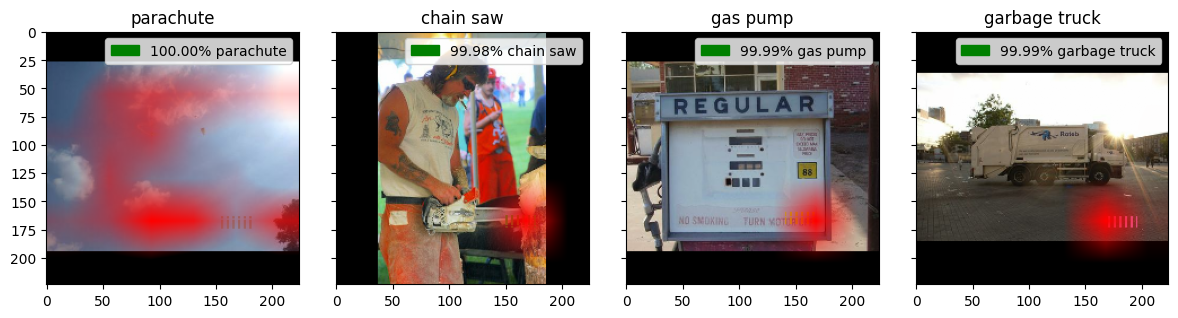

### Model B

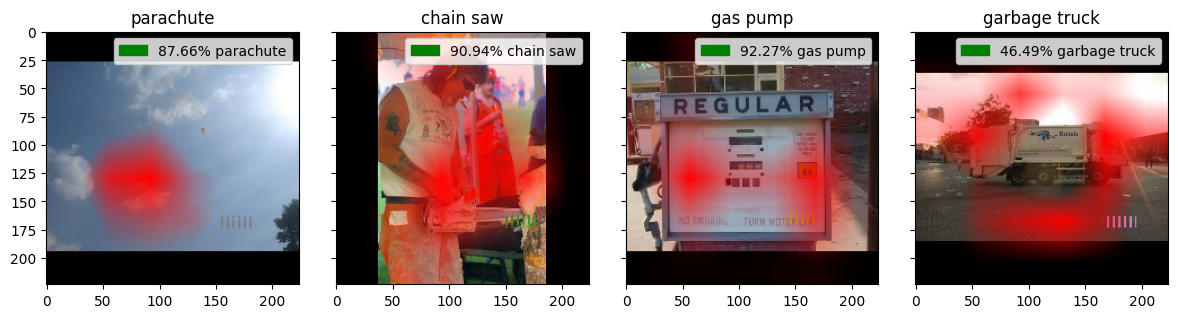

## Batch 2

### Model A

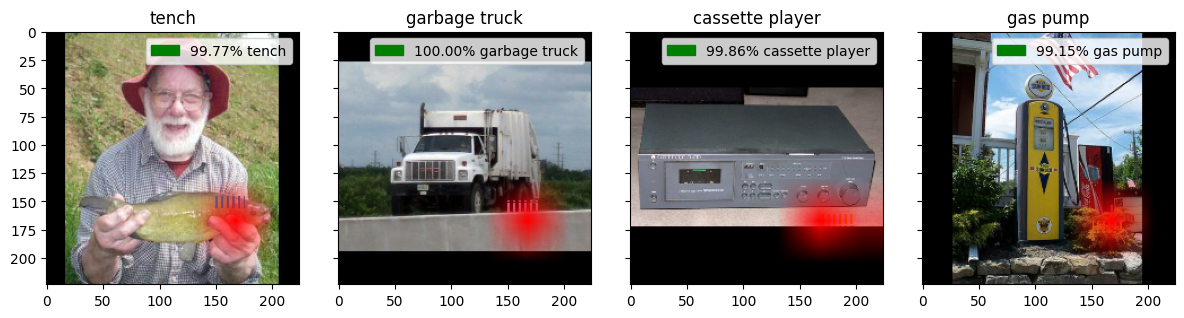

### Model B

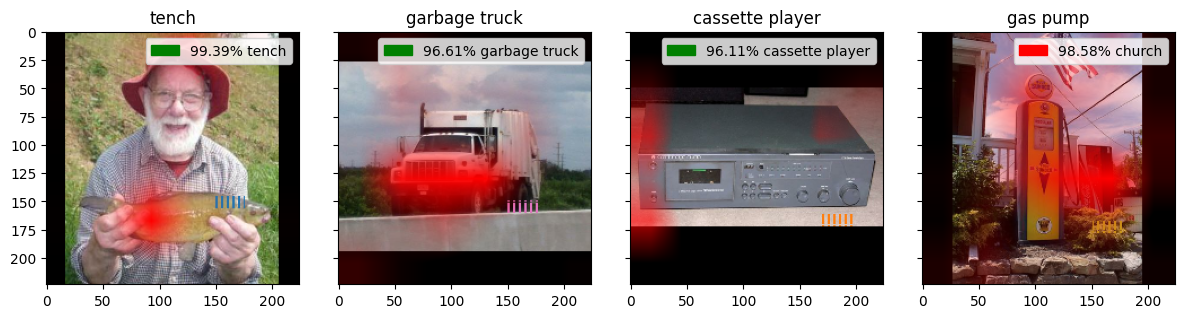

In [12]:
ds_val = create_dataset(".", batch_size=4)

logits_fn_a, variables_a = load_checkpoint(f"{OUTPUT_PATH}/biased")
logits_fn_b, variables_b = load_checkpoint(f"{OUTPUT_PATH}/unbiased")

for batch_idx, (images, labels) in enumerate(ds_val):
    display(Markdown(f"## Batch {batch_idx}"))

    display(Markdown(f"### Model A"))
    logits, relevance = explanation_fn(logits_fn_a, variables_a, images)
    show_images(
        blend(images, RED, relevance.clip(min=0)[..., None]),
        labels,
        logits,
    )

    display(Markdown(f"### Model B"))
    logits, relevance = explanation_fn(logits_fn_b, variables_b, images)
    show_images(
        blend(images, RED, relevance.clip(min=0)[..., None]),
        labels,
        logits,
    )

    if batch_idx >= 2:
        break